In [9]:
# Imports
import pickle
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../../../')

from src import customFunc as cf
from src import ansatzs as anz
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.providers.fake_provider import FakeMelbourneV2
import time
from qiskit.quantum_info import Statevector

In [2]:
with open(f"data/ansatz1.000.pkl", "rb") as f:
    ansatz_naive = pickle.load(f)

backend = FakeMelbourneV2()

# Transpile circuit with a pass manager for a backend
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
t0 = time.time()
transpiled_ansatz_naive = pm.run(ansatz_naive)
t1 = time.time()
t_optimized=t1 - t0

# Show results
print(f"Transpilation time: {t_optimized} (s)")
print(f'Circuit info: {transpiled_ansatz_naive.count_ops()}')
print(f'Depth: {transpiled_ansatz_naive.depth()}')

#ansatz_naive.decompose().draw('mpl')

Transpilation time: 60.619348764419556 (s)
Circuit info: OrderedDict([('cx', 14210), ('rz', 7269), ('sx', 4987), ('x', 279)])
Depth: 19695


In [3]:
ansatz_opt=anz.optimize_ansatz(ansatz_naive)

# Transpile circuit with a pass manager for a backend
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
t0 = time.time()
transpiled_ansatz_opt = pm.run(ansatz_opt)
t1 = time.time()
t_optimized=t1 - t0

# Show results
print(f"Transpilation time: {t_optimized} (s)")
print(f'Circuit info: {transpiled_ansatz_opt.count_ops()}')
print(f'Depth: {transpiled_ansatz_opt.depth()}')

Transpilation time: 47.636719703674316 (s)
Circuit info: OrderedDict([('cx', 14148), ('rz', 6679), ('sx', 4047), ('x', 1000)])
Depth: 19453


## Comparison of ansatz

In [10]:
# Randomización de parámetros
num_params = ansatz_naive.num_parameters
x0 = np.random.uniform(0,2*np.pi,num_params)

# Ansatz sin optimizar
qc_1 = ansatz_naive.assign_parameters({list(ansatz_naive.parameters)[i]: x0[i] for i in range(len(x0))}) # Asignamos los parámetros al circuito
Sv_1 = Statevector(qc_1)
display(Sv_1.draw('latex'))

# Ansatz optimizado
qc_2 = ansatz_opt.assign_parameters({list(ansatz_opt.parameters)[i]: x0[i] for i in range(len(x0))}) # Asignamos los parámetros al circuito
Sv_2 = Statevector(qc_2)
display(Sv_2.draw('latex'))

# Fidelidad y distancia
print(abs(np.dot(Sv_1,Sv_2)))
print(abs(np.linalg.norm(Sv_1-Sv_2)))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

0.99999999999873
1.585860267019861e-13


# Pruebas

In [4]:
ansatz_naive
num_qubits=4

# Transpile circuit with a pass manager for a backend
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
t0 = time.time()
transpiled_ansatz_naive = pm.run(ansatz_naive)
t1 = time.time()
t_optimized=t1 - t0

# Show results
print(f"Transpilation time: {t_optimized} (s)")
print(f'Circuit info: {transpiled_ansatz_naive.count_ops()}')
print(f'Depth: {transpiled_ansatz_naive.depth()}')

display(ansatz_naive.decompose(reps=1).draw('mpl'))
display(transpiled_ansatz_naive.draw('mpl'))

KeyboardInterrupt: 

In [ ]:
swap_strategy = SwapStrategy.from_line([i for i in range(num_qubits)])
edge_coloring = {(idx, idx + 1): (idx + 1) % 2 for idx in range(num_qubits)}

# Define pass manager
init_cost_layer = PassManager([FindCommutingPauliEvolutions(), Commuting2qGateRouter(swap_strategy, edge_coloring,), HighLevelSynthesis(basis_gates=["x", "u", "h", "cx", "sx", "rz", "rx"]), InverseCancellation(gates_to_cancel=[CXGate()])])
ansatz_opt=init_cost_layer.run(ansatz_naive)

# Transpile circuit with a pass manager for a backend
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
t0 = time.time()
transpiled_ansatz_opt = pm.run(ansatz_opt)
t1 = time.time()
t_optimized=t1 - t0

# Show results
print(f"Transpilation time: {t_optimized} (s)")
print(f'Circuit info: {transpiled_ansatz_opt.count_ops()}')
print(f'Depth: {transpiled_ansatz_opt.depth()}')
display(ansatz_opt.draw('mpl'))
display(transpiled_ansatz_opt.draw('mpl'))

NameError: name 'SwapStrategy' is not defined

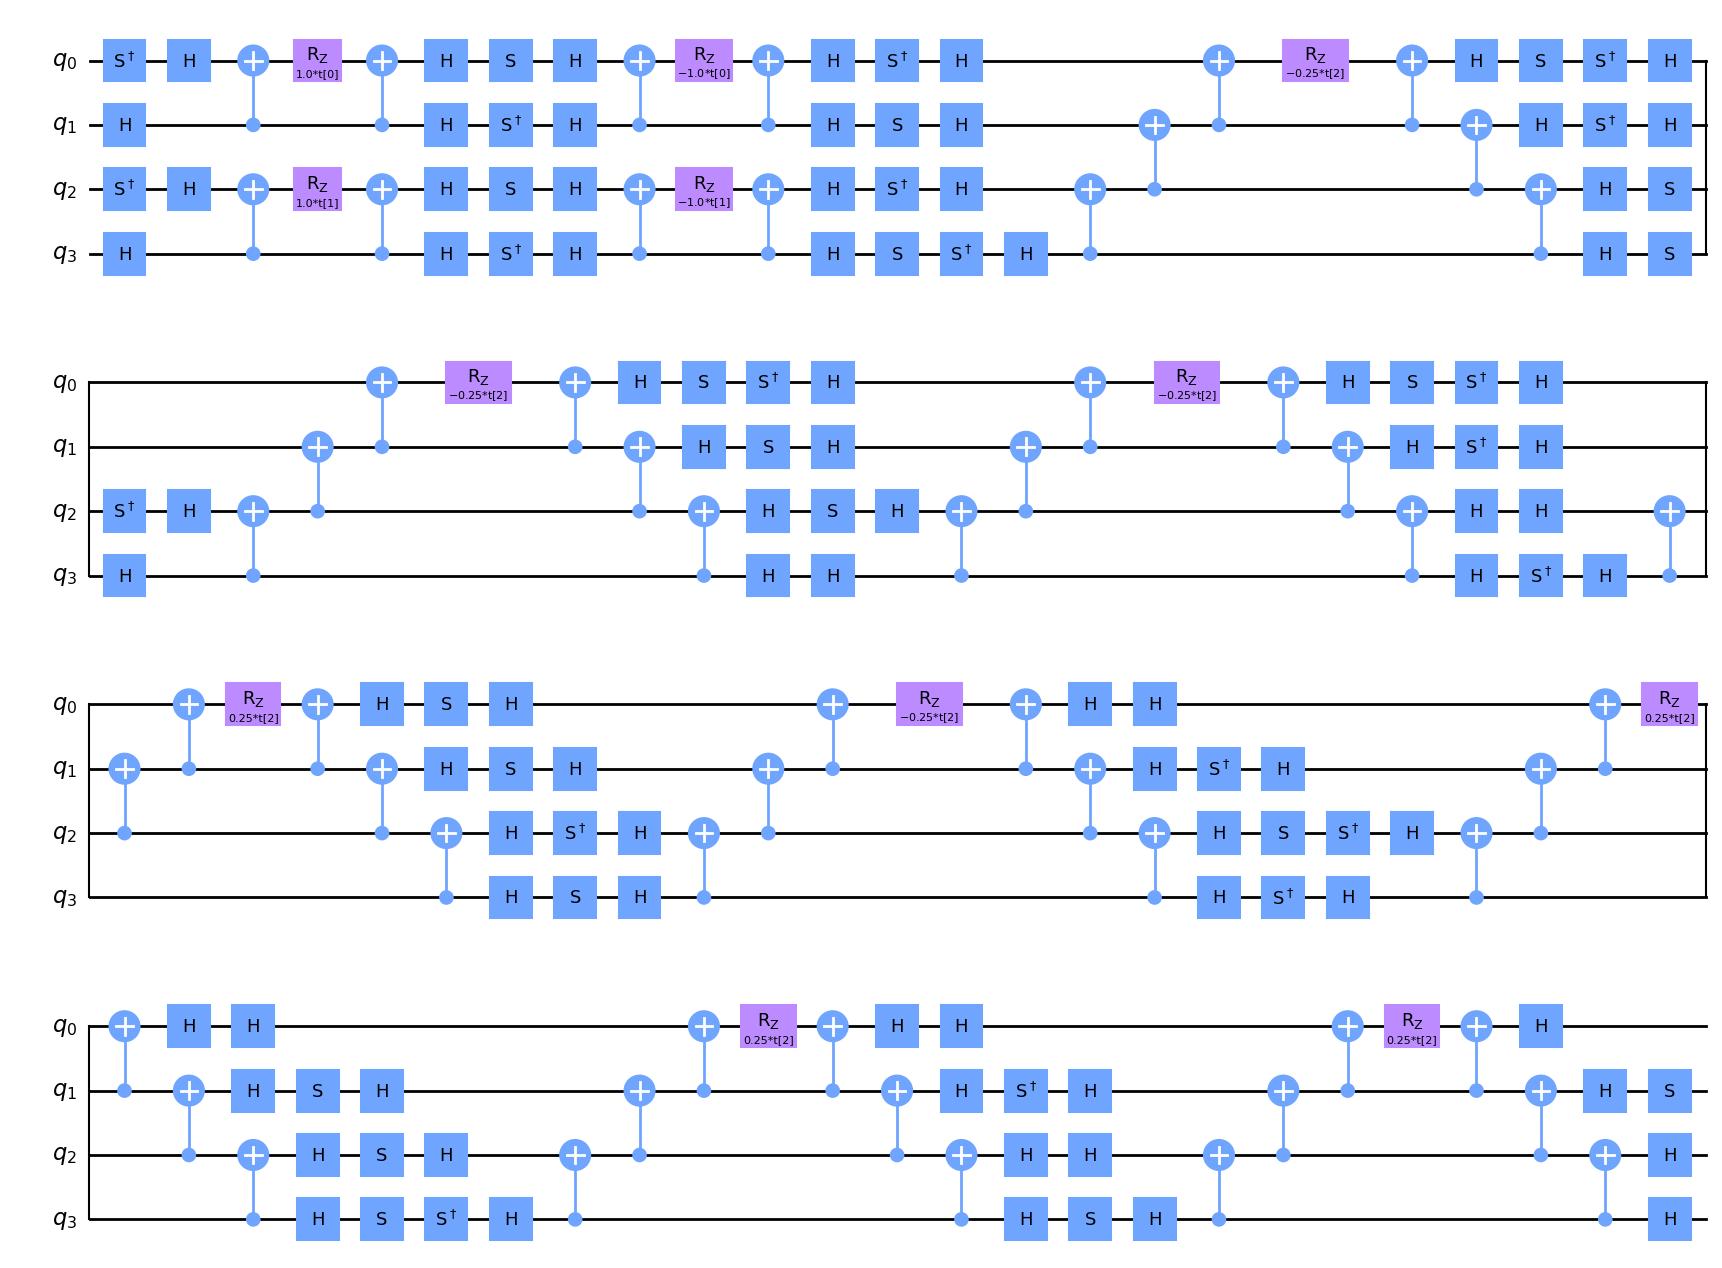

In [ ]:
a=QuantumCircuit(ansatz_naive.num_qubits)
a.append(ansatz_naive.to_instruction(), a.qubits)
b=QuantumCircuit(4)
for instruction in a.decompose(reps=2).data[2:]:  # Ignora el primer elemento (índice 0)
    b.append(instruction.operation, instruction.qubits)
b.decompose(reps=2).draw('mpl')

In [ ]:
def optimize_ansatz(ansatz_naive):
    # Choose swap strategy (in this case -> line)
    num_qubits=ansatz_naive.num_qubits
    swap_strategy = SwapStrategy.from_line([i for i in range(num_qubits)])
    edge_coloring = {(idx, idx + 1): (idx + 1) % 2 for idx in range(num_qubits)}

    # Define pass manager
    init_cost_layer = PassManager([FindCommutingPauliEvolutions(), Commuting2qGateRouter(swap_strategy, edge_coloring,), HighLevelSynthesis(basis_gates=["x", "u", "h", "cx", "sx", "rz", "rx"]), InverseCancellation(gates_to_cancel=[CXGate()])])

    # Create a circuit for the 2 qubit gates and optimize it with the cost layer pass manager
    ansatz_opt=init_cost_layer.run(ansatz_naive)

    return ansatz_opt